In [23]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import random
import nltk
import string
import re

In [24]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import svm, preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, LSTM, Dense, Dropout
import joblib
import pickle
import os
from sklearn.metrics.pairwise import cosine_similarity


In [25]:
# Load dataset
df = pd.read_csv(r"D:\chatbot\20200325_counsel_chat.csv", encoding="utf-8")

In [26]:
# Cleaning function
def clean(column, df, stopwords_flag=False):
    df[column] = df[column].astype(str).str.lower().str.split()
    if stopwords_flag:
        stop_w = stopwords.words('english')
        df[column] = df[column].apply(lambda x: [item for item in x if item not in stop_w])
    df[column] = df[column].apply(lambda x: [item for item in x if item not in string.punctuation])
    df[column] = df[column].apply(lambda x: " ".join(x))

In [27]:
# Apply cleaning
df['questionTitle'] = df['questionTitle'].astype(str)
df['questionText'] = df['questionText'].astype(str)
clean('questionTitle', df)
clean('questionText', df)

In [28]:
# Combine title and text
X = df['questionTitle'] + " " + df['questionText']
y = df['topic']
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

In [29]:
# Save label encoder
joblib.dump(le, 'newle.joblib')
joblib.dump(y, 'labelencoder.joblib')

['labelencoder.joblib']

In [30]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [31]:
# TF-IDF + Logistic Regression Pipeline
logreg = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(penalty='l2'))
])
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(f"Test accuracy: {accuracy_score(y_test, y_pred):.4f}")

Test accuracy: 0.6948


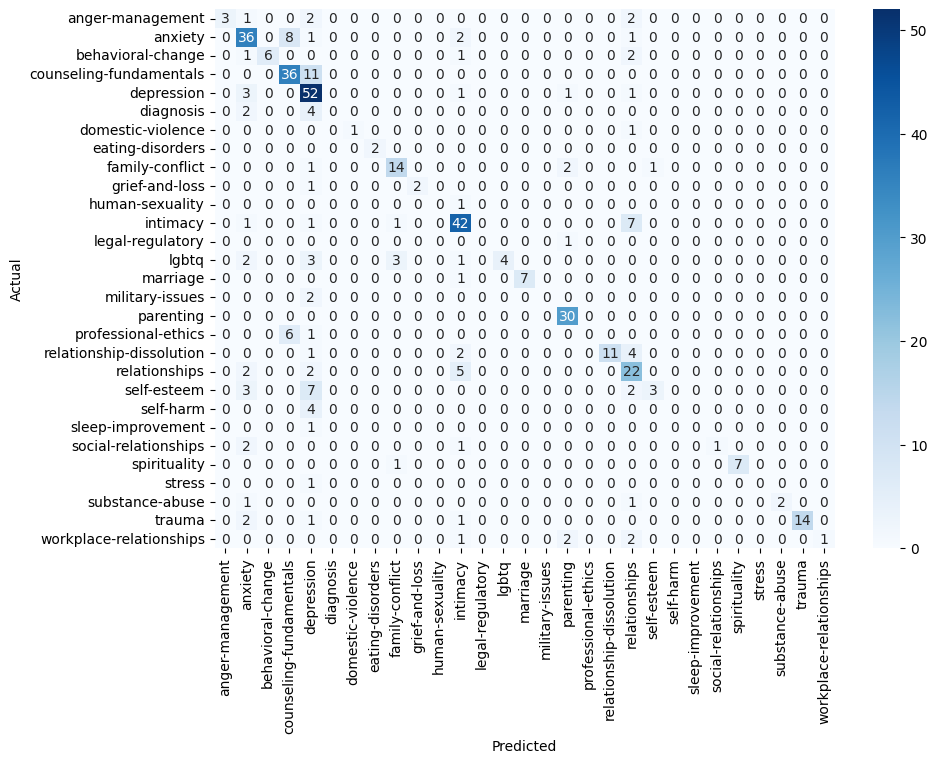

In [32]:
from numpy import unique

# Confusion matrix
data = confusion_matrix(y_test, y_pred)
labels_in_test = np.unique(y_test)
class_names = le.inverse_transform(labels_in_test)

df_cm = pd.DataFrame(data, columns=class_names, index=class_names)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, cmap="Blues", annot=True, fmt='d')
plt.show()


In [33]:
# Tokenizer for deep learning model
NB_WORDS = 5000
NB_EPOCHS = 15
BATCH_SIZE = 32
MAX_LEN = 200

In [34]:
tokenizer = Tokenizer(num_words=NB_WORDS, filters='"#$%&()*+-/:;<=>@[\\]^_`{|}~')
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_LEN)
y_train_cat = to_categorical(y_train)
joblib.dump(tokenizer, 'tokenizer.joblib')

['tokenizer.joblib']

In [35]:
# Deep learning model
model = Sequential([
    Input(shape=(MAX_LEN,)),
    Embedding(input_dim=NB_WORDS, output_dim=256),
    SpatialDropout1D(0.3),
    LSTM(256, dropout=0.2),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.fit(X_train_seq, y_train_cat, validation_split=0.1, epochs=NB_EPOCHS, batch_size=BATCH_SIZE, callbacks=[callback])
model.save('chatbot.h5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 256)          1280000   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 200, 256)         0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 31)                3999      
                                                      

In [36]:
# Prediction function with KNN support
def predict_and_find_similar(user_texts):
    user_df = pd.DataFrame(user_texts, columns=['text'])
    clean('text', user_df)
    texts_cleaned = user_df['text'].tolist()
    x_input = tokenizer.texts_to_sequences(texts_cleaned)
    x_input = pad_sequences(x_input, maxlen=MAX_LEN)
    preds = model.predict(x_input)
    labels = le.inverse_transform(np.argmax(preds, axis=1))
     # KNN
    df_copy = df.copy()
    clean('questionText', df_copy)
    knn_input = tokenizer.texts_to_sequences(df_copy['questionText'])
    knn_input = pad_sequences(knn_input, maxlen=MAX_LEN)
    model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5)
    model_knn.fit(knn_input)
    distances, indices = model_knn.kneighbors(x_input)

    for i, text in enumerate(user_texts):
        print(f"\nInput: {text}")
        print(f"Predicted Label: {labels[i]}")
        print("Similar Training Examples:")
        for idx in indices[i]:
            print(f" - {df.iloc[idx]['questionText']} → Label: {df.iloc[idx]['topic']}")

In [37]:
# Example prediction
predict_and_find_similar([
    "I feel really depressed and want to cry all day.",
    "He hit me again and broke my phone."
])


1/1 [==============================] - 2s 2s/step

Input: I feel really depressed and want to cry all day.
Predicted Label: counseling-fundamentals
Similar Training Examples:
 - these "jokes" are made about everything. they seem to have the need to say something "funny" about everything. it's not funny, just awkward. → Label: social-relationships
 - my boyfriend is in ireland for 11 days, and i am an emotional wreck. → Label: relationships
 - nothing we've tried has worked so far. → Label: intimacy
 - nothing we've tried has worked so far. → Label: intimacy
 - i always need alcohol to feel better and use that as a excuse. → Label: self-esteem

Input: He hit me again and broke my phone.
Predicted Label: counseling-fundamentals
Similar Training Examples:
 - these "jokes" are made about everything. they seem to have the need to say something "funny" about everything. it's not funny, just awkward. → Label: social-relationships
 - i always need alcohol to feel better and use that as a excus

In [38]:
if embedding_model:
    question = "How do I deal with stress and anxiety?"
    question_embedding = embedding_model.encode([question]).reshape(1, -1)
    sentences = df['questionText'].tolist()
    bow_corpus = [embedding_model.encode([s]).reshape(1, -1) for s in sentences]

    def retrieveAndPrintFAQAnswer(question_embedding, sentence_embeddings, FAQdf, sentences):
        max_sim, index_sim = -1, -1
        for index, faq_embedding in enumerate(sentence_embeddings):
            sim = cosine_similarity(faq_embedding, question_embedding)[0][0]
            if sim > max_sim:
                max_sim, index_sim = sim, index
        print("\nQuestion:", question)
        print("\nRetrieved:")
        print("→", FAQdf.iloc[index_sim, 0])
        print("→", FAQdf.iloc[index_sim, 1])

    retrieveAndPrintFAQAnswer(question_embedding, bow_corpus, df, sentences)

    # Save question-answer dictionary
    dict_qa = {}
    for _, row in df.iterrows():
        topic = row['topic']
        dict_qa.setdefault(topic, []).append(row['answerText'])

    with open("topic_answers.pkl", "wb") as f:
        pickle.dump(dict_qa, f)

    # Generate embeddings and save
    os.makedirs("model", exist_ok=True)
    questions = df['questionText'].astype(str).tolist()
    answers = df['answerText'].astype(str).tolist()
    question_embeddings = embedding_model.encode(questions, convert_to_numpy=True)
    answer_embeddings = embedding_model.encode(answers, convert_to_numpy=True)

    joblib.dump(question_embeddings, 'model/questionembedding.dump')
    joblib.dump(answer_embeddings, 'model/ansembedding.dump')
    print("Embeddings saved to model folder.")
